In [1]:
# import some of the libaries that we will use
import urllib.request
import io
import itertools as it
import os
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

from thefuzz import process
from thefuzz import fuzz

import json

import colorcet as cc
import panel as pn
import panel.widgets as pnw

import translate_app
import recordlinkage as rl
import missingno as msno
import holoviews as hv
import hvplot
import hvplot.pandas

In [2]:
# get the zip file with the data from the link

data_url = (
    "https://storage.googleapis.com/mrprime_dataset/dogs_of_zurich/dogs_of_zurich.zip"
)

# create function which takes the url
# retrieve zip and unzip it and return the csv files as a list


def get_data(url):
    """Function which takes in a url, retrieves the zip file,
    unzips it and returns the csv files as a list"""
    # get the zip file
    filename, headers = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(filename) as zip_ref:
        # get the csv files
        dfs = []
        for file in zip_ref.namelist():
            if file.endswith(".csv"):
                csv_file = io.StringIO(zip_ref.read(file).decode("utf-8"))
                # readin csv as a pandas dataframe and append to list
                df = pd.DataFrame()
                df = pd.read_csv(csv_file)
                df["roster"] = file
                dfs.append(df)

    return dfs

In [3]:
# call the function and assign the csv files to a variable
dogs_of_zurich_dfs = get_data(data_url)

In [4]:
# Put all the column headers in one list
list_of_headings = []
for df in dogs_of_zurich_dfs:
    list_of_headings += df.columns.tolist()

more_german_words = list(
    filter(lambda x: x is not np.nan, dogs_of_zurich_dfs[3].iloc[:, 2].unique())
)
list_of_headings += more_german_words

In [5]:
# Only keep unique column headers and replace underscores with spaces

words_set = {word.replace("_", " ") for word in list_of_headings}
words_set

{'ALTER',
 'GEBURTSJAHR HUND',
 'GESCHLECHT',
 'GESCHLECHT HUND',
 'HALTER ID',
 'HUNDEFARBE',
 'HUNDERASSE',
 'HUNDERASSENTYP',
 'HUNDERASSENTYP KURZ',
 'Kleinwüchsig',
 'RASSE1',
 'RASSE1 MISCHLING',
 'RASSE2',
 'RASSE2 MISCHLING',
 'RASSENTYP',
 'Rassentypenliste I',
 'Rassentypenliste II',
 'STADTKREIS',
 'STADTQUARTIER',
 'roster'}

#### Run translate app for columns

In [6]:
# translate headers using the translate app
translated_words = translate_app.translate_list(words_set)
translated_words

{'HUNDEFARBE': 'DOG COLOR',
 'RASSENTYP': 'BREED TYPE',
 'Kleinwüchsig': 'Short stature',
 'GESCHLECHT': 'GENDER',
 'RASSE1 MISCHLING': 'BREED1 MIXED BREED',
 'GEBURTSJAHR HUND': "DOG'S YEAR OF BIRTH",
 'Rassentypenliste II': 'Breed type list II',
 'HALTER ID': 'HOLDER ID',
 'roster': 'roster',
 'GESCHLECHT HUND': 'GENDER DOG',
 'HUNDERASSENTYP': 'DOG BREED TYPE',
 'RASSE1': 'BREED1',
 'STADTKREIS': 'CITY CIRCLE',
 'HUNDERASSE': 'DOG BREED',
 'STADTQUARTIER': 'CITY QUARTER',
 'HUNDERASSENTYP KURZ': 'DOG BREED TYPE SHORT',
 'RASSE2': 'BREED2',
 'Rassentypenliste I': 'Breed type list I',
 'ALTER': 'AGE',
 'RASSE2 MISCHLING': 'BREED2 MIXED BREED'}

In [7]:
# put the underscores back in the original headings
translated_headings_underscores = {
    key.replace(" ", "_"): value.lower().replace(" ", "_").replace("'s", "")
    for key, value in translated_words.items()
}
translated_headings_underscores

{'HUNDEFARBE': 'dog_color',
 'RASSENTYP': 'breed_type',
 'Kleinwüchsig': 'short_stature',
 'GESCHLECHT': 'gender',
 'RASSE1_MISCHLING': 'breed1_mixed_breed',
 'GEBURTSJAHR_HUND': 'dog_year_of_birth',
 'Rassentypenliste_II': 'breed_type_list_ii',
 'HALTER_ID': 'holder_id',
 'roster': 'roster',
 'GESCHLECHT_HUND': 'gender_dog',
 'HUNDERASSENTYP': 'dog_breed_type',
 'RASSE1': 'breed1',
 'STADTKREIS': 'city_circle',
 'HUNDERASSE': 'dog_breed',
 'STADTQUARTIER': 'city_quarter',
 'HUNDERASSENTYP_KURZ': 'dog_breed_type_short',
 'RASSE2': 'breed2',
 'Rassentypenliste_I': 'breed_type_list_i',
 'ALTER': 'age',
 'RASSE2_MISCHLING': 'breed2_mixed_breed'}

In [8]:
# This is actually translated to districts as in the 12 districts of Zurich
translated_headings_underscores["STADTKREIS"] = "district"

In [9]:
# put the translated headings as the new column names
for df in dogs_of_zurich_dfs:
    df.rename(columns=translated_headings_underscores, inplace=True)

#### Get the 2 dataframes

In [10]:
# Combine 3 of 4 dataframes into one with dog owner info
dog_owner_df = pd.DataFrame()
dog_owner_df = pd.concat(
    [dogs_of_zurich_dfs[0], dogs_of_zurich_dfs[1], dogs_of_zurich_dfs[2]], axis=0
)
dog_owner_df.info()

# name last dataframe with dog breeds info
dog_df = pd.DataFrame()
dog_df = dogs_of_zurich_dfs[3]
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21065 entries, 0 to 7154
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   holder_id           21065 non-null  int64  
 1   age                 21060 non-null  object 
 2   gender              21065 non-null  object 
 3   district            21060 non-null  float64
 4   city_quarter        21060 non-null  float64
 5   breed1              21065 non-null  object 
 6   breed1_mixed_breed  1939 non-null   object 
 7   breed2              1590 non-null   object 
 8   breed2_mixed_breed  0 non-null      float64
 9   breed_type          20891 non-null  object 
 10  dog_year_of_birth   21065 non-null  int64  
 11  gender_dog          21065 non-null  object 
 12  dog_color           21065 non-null  object 
 13  roster              21065 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [11]:
display(dog_owner_df.sample(3))
dog_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed2_mixed_breed,breed_type,dog_year_of_birth,gender_dog,dog_color,roster
886,83993,61-70,w,7.0,73.0,Mischling klein,NaN,NaN,NaN,K,2009,m,schwarz/weiss,20170308hundehalter.csv
5897,127843,61-70,m,8.0,81.0,Cairn Terrier,NaN,NaN,NaN,K,2009,w,rot/braun,20170308hundehalter.csv
1062,84517,71-80,w,7.0,71.0,Deerhound,NaN,NaN,NaN,I,2006,w,grau,20151001hundehalter.csv


,dog_breed,dog_breed_type_short,dog_breed_type,roster
330,Transylvanischer Laufhund,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
305,Sibirischer Husky,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
296,Scottish Terrier,K,Kleinwüchsig,zuordnungstabellehunderassehundetyp.csv


<Axes: >

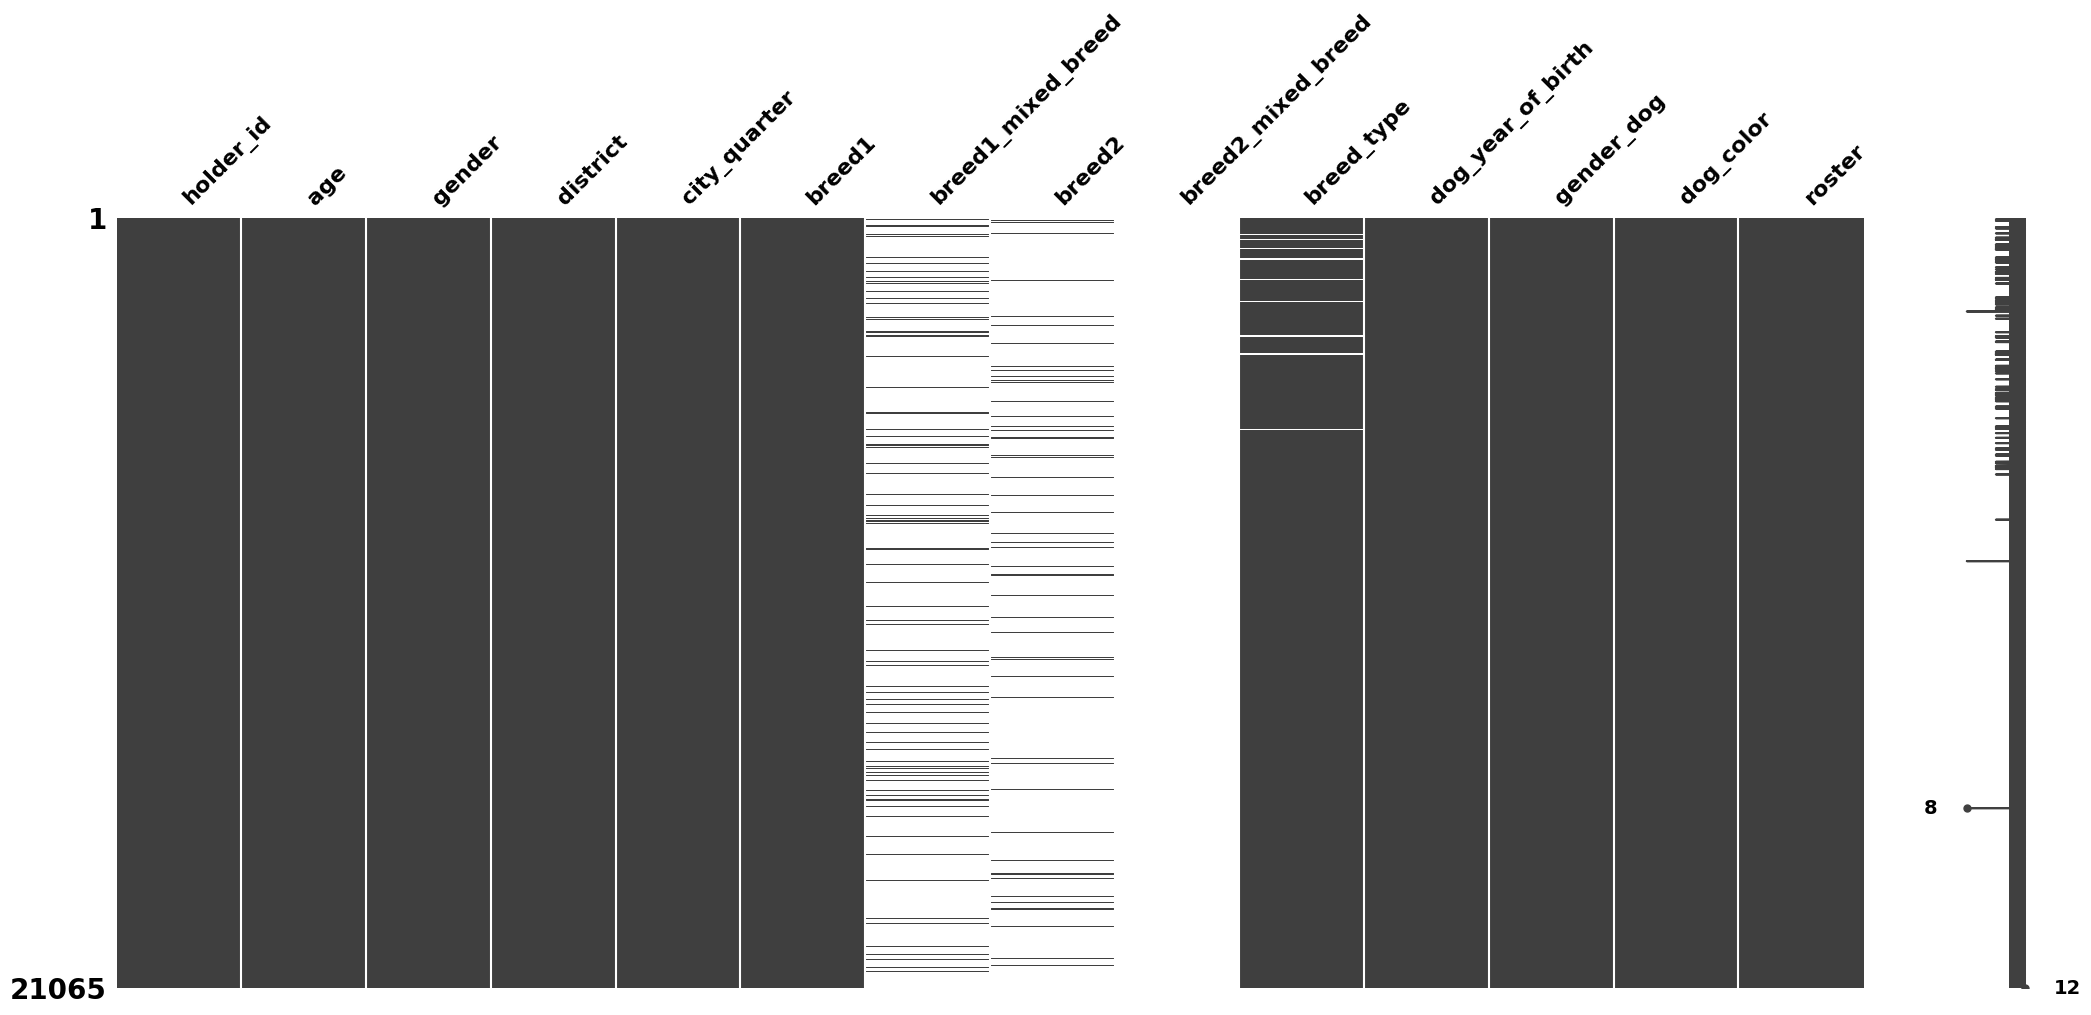

In [12]:
msno.matrix(dog_owner_df)

In [13]:
# only null values in breed2_mixed so drop column
dog_owner_df = dog_owner_df.drop(columns=["breed2_mixed_breed"])

<Axes: >

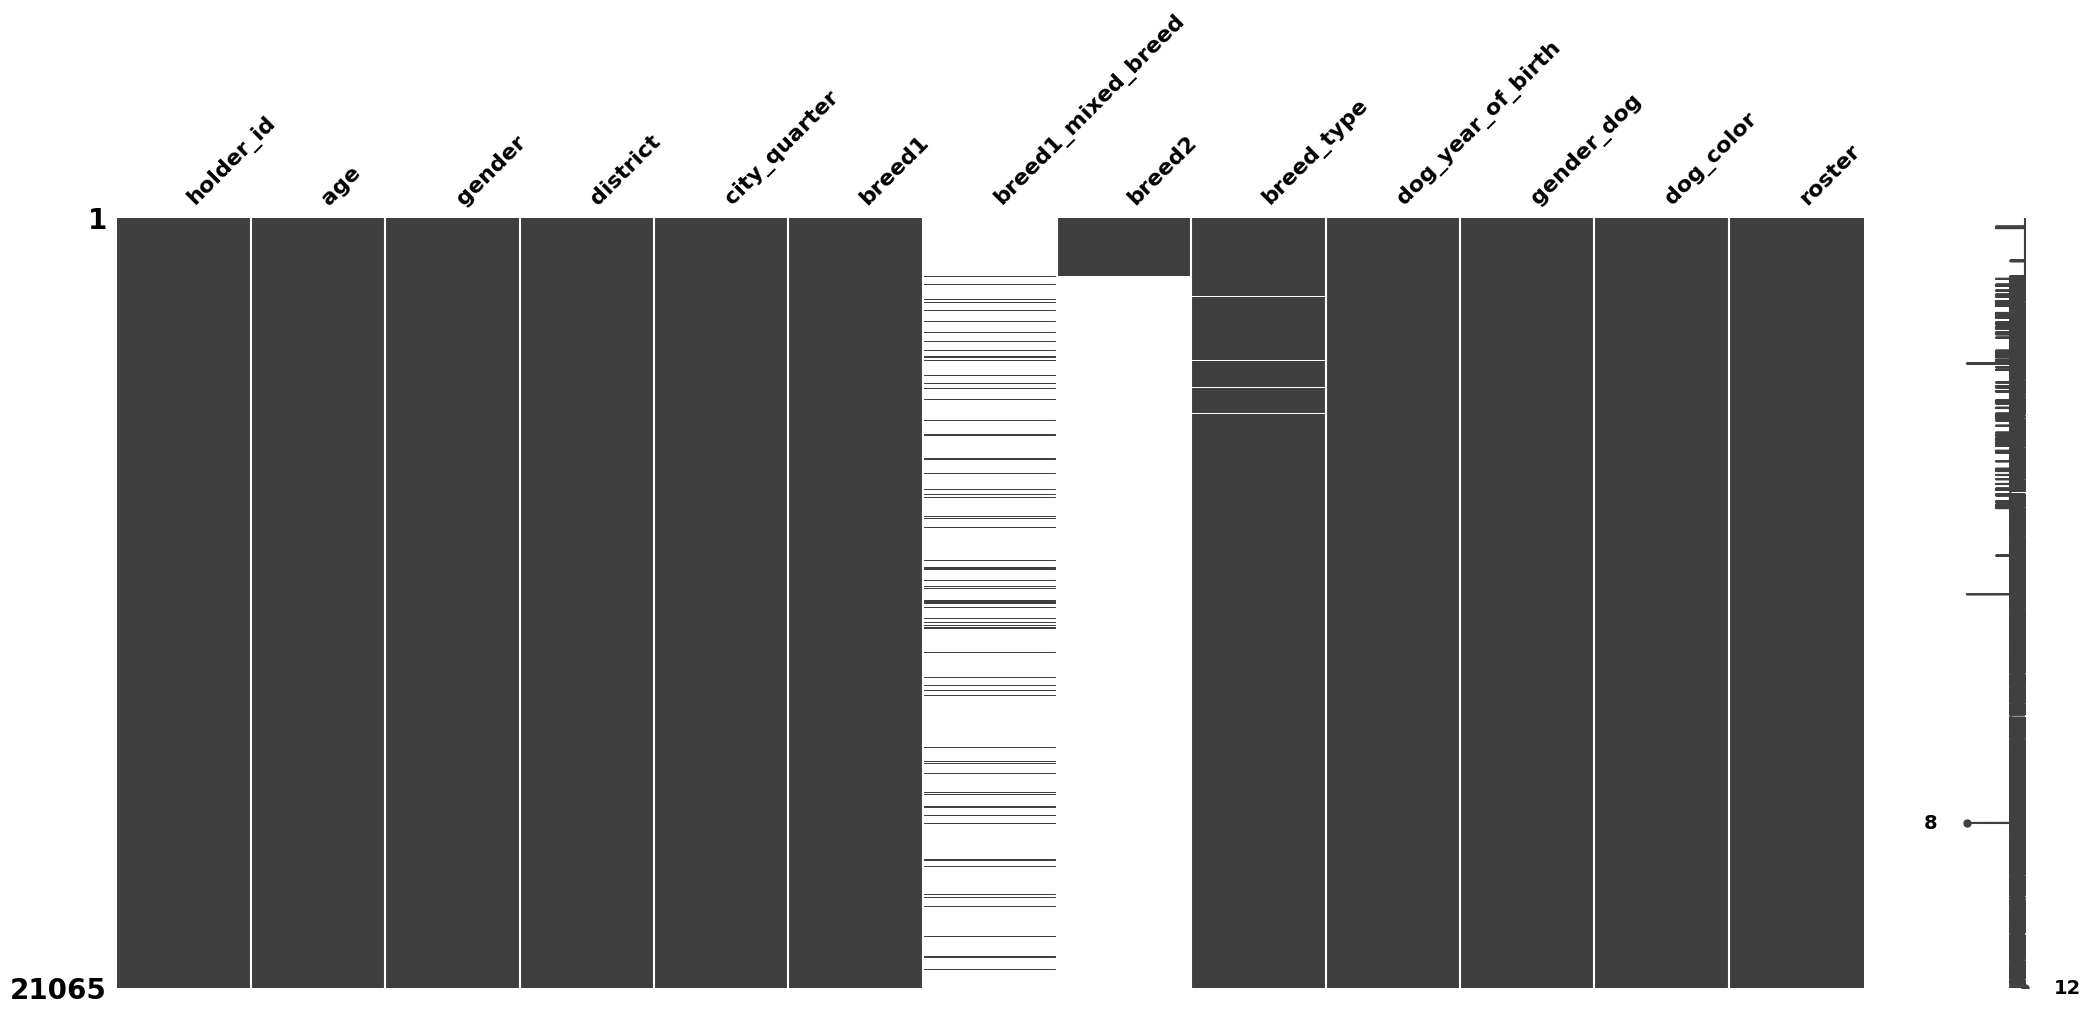

In [14]:
msno.matrix(dog_owner_df.sort_values(by=["breed2"]))

In [15]:
# reset index
dog_owner_df = dog_owner_df.reset_index(drop=True)
# make the district column a category
dog_owner_df["district"] = dog_owner_df["district"].astype("category")

# take the first 4 char of roster only and make it an ordered category colummn
dog_owner_df["roster"] = dog_owner_df["roster"].str[:4]
dog_owner_df["roster"] = pd.Categorical(dog_owner_df["roster"], ordered=True)


# add a column with the first year the owner appeared in the roster
dog_owner_df["first_appearance"] = dog_owner_df.groupby("holder_id")[
    "roster"
].transform("min")

# add column for the numberr of appearances in the roster
dog_owner_df["appearances"] = dog_owner_df.groupby("holder_id")["roster"].transform(
    "nunique"
)

# add a column with the number of dogs per owner
dog_owner_df["dog_count"] = dog_owner_df.groupby(["holder_id", "roster"])[
    "holder_id"
].transform("size")

dog_owner_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
8096,85165,61-70,w,7.0,71.0,Boxer,NaN,NaN,I,2008,m,schwarz/braun,2016,2015,3,1
7426,81557,71-80,w,2.0,24.0,Labrador Retriever,Mischling,NaN,I,2004,w,schwarz,2016,2015,3,1
15161,86282,51-60,w,2.0,24.0,Podenco,Mischling,NaN,I,2007,m,beige,2017,2015,3,2


Dog with a year of birth after the roster year

In [16]:
# get the holder_id of the bad entries and observe other entries with the same holder_id
bad_entry_holder_id = dog_owner_df[
    dog_owner_df["dog_year_of_birth"] > dog_owner_df["roster"].astype(int)
]["holder_id"]


dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].sort_values(
    by="holder_id"
)

# dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].index

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
4543,111954,41-50,w,3.0,34.0,Parson Russell Terrier,NaN,NaN,K,5012,m,tricolor,2015,2015,2,1
11296,111954,51-60,w,3.0,34.0,Parson Russell Terrier,NaN,NaN,K,5012,m,tricolor,2016,2015,2,1
5608,121585,41-50,m,7.0,74.0,Malteser,NaN,NaN,K,2016,m,weiss,2015,2015,3,1
12282,121585,41-50,m,7.0,74.0,Malteser,NaN,NaN,K,2016,m,weiss,2016,2015,3,1
18798,121585,41-50,m,7.0,74.0,Malteser,NaN,NaN,K,2016,m,weiss,2017,2015,3,1


Since we have Rosters for 3 separate years, we can see if that owner corrected its wrong entry in the later years. We can drop since the bad entries are consistent with no clue as to the correct entry.

In [17]:
display(dog_owner_df.shape)

bad_entry_index = dog_owner_df[
    dog_owner_df["holder_id"].isin(bad_entry_holder_id)
].index

dog_owner_df.drop(bad_entry_index, inplace=True)

dog_owner_df.info()

(21065, 16)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21060 entries, 0 to 21064
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   holder_id           21060 non-null  int64   
 1   age                 21055 non-null  object  
 2   gender              21060 non-null  object  
 3   district            21055 non-null  category
 4   city_quarter        21055 non-null  float64 
 5   breed1              21060 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1590 non-null   object  
 8   breed_type          20886 non-null  object  
 9   dog_year_of_birth   21060 non-null  int64   
 10  gender_dog          21060 non-null  object  
 11  dog_color           21060 non-null  object  
 12  roster              21060 non-null  category
 13  first_appearance    21060 non-null  category
 14  appearances         21060 non-null  int64   
 15  dog_count           21060 non-null  

Dogs with a year of birth too far before the roster year (before 1990) which is plausible, but not probable

In [18]:
# get the holder_id of the bad entries
bad_entry_holder_id = dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990][
    "holder_id"
]

# isolate entries from these holder_ids and group them by holder_id
dog_owner_group = (
    dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)]
    .sort_values(by="holder_id")
    .groupby("holder_id")
)

dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].sort_values(
    by="holder_id"
)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
2659,91351,41-50,m,7.0,72.0,Mops,NaN,NaN,K,1980,w,beige/schwarz,2015,2015,3,1
9485,91351,41-50,m,7.0,72.0,Mops,NaN,NaN,K,2009,w,beige/schwarz,2016,2015,3,1
16238,91351,41-50,m,7.0,72.0,Mops,NaN,NaN,K,2009,w,beige/schwarz,2017,2015,3,1
2901,94655,41-50,w,2.0,24.0,Labrador Retriever,NaN,NaN,I,8,w,braun,2015,2015,3,1
9712,94655,41-50,w,2.0,24.0,Labrador Retriever,NaN,NaN,I,2008,w,braun,2016,2015,3,1
16448,94655,41-50,w,2.0,24.0,Labrador Retriever,NaN,NaN,I,2008,w,braun,2017,2015,3,1
3165,98411,71-80,w,11.0,119.0,Labrador Retriever,NaN,NaN,I,1,w,schwarz,2015,2015,3,1
9966,98411,71-80,w,11.0,119.0,Labrador Retriever,NaN,NaN,I,2001,w,schwarz,2016,2015,3,1
16689,98411,71-80,w,11.0,119.0,Labrador Retriever,NaN,NaN,I,2001,w,schwarz,2017,2015,3,1
3521,100070,51-60,w,9.0,92.0,Pekingese,NaN,NaN,K,1962,m,braun/schwarz,2015,2015,3,1


We can replace bad entries with matching entries from the later roster years as the owner corrected the value for th elater rosters. Luckly these owners only have one dog each.

The one bad entry of `1980` with only 1 appearance we cannot safely replace so we drop it.

In [19]:
# these entries only have 1 dog so we can replace the year of birth with the mode making some assumptions
dog_owner_df.loc[
    dog_owner_df["holder_id"].isin(bad_entry_holder_id), "dog_year_of_birth"
] = dog_owner_group["dog_year_of_birth"].transform(lambda x: x.mode().iloc[0])

dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].sort_values(
    by="holder_id"
)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
2659,91351,41-50,m,7.0,72.0,Mops,NaN,NaN,K,2009,w,beige/schwarz,2015,2015,3,1
9485,91351,41-50,m,7.0,72.0,Mops,NaN,NaN,K,2009,w,beige/schwarz,2016,2015,3,1
16238,91351,41-50,m,7.0,72.0,Mops,NaN,NaN,K,2009,w,beige/schwarz,2017,2015,3,1
2901,94655,41-50,w,2.0,24.0,Labrador Retriever,NaN,NaN,I,2008,w,braun,2015,2015,3,1
9712,94655,41-50,w,2.0,24.0,Labrador Retriever,NaN,NaN,I,2008,w,braun,2016,2015,3,1
16448,94655,41-50,w,2.0,24.0,Labrador Retriever,NaN,NaN,I,2008,w,braun,2017,2015,3,1
3165,98411,71-80,w,11.0,119.0,Labrador Retriever,NaN,NaN,I,2001,w,schwarz,2015,2015,3,1
9966,98411,71-80,w,11.0,119.0,Labrador Retriever,NaN,NaN,I,2001,w,schwarz,2016,2015,3,1
16689,98411,71-80,w,11.0,119.0,Labrador Retriever,NaN,NaN,I,2001,w,schwarz,2017,2015,3,1
3521,100070,51-60,w,9.0,92.0,Pekingese,NaN,NaN,K,2006,m,braun/schwarz,2015,2015,3,1


In [20]:
dog_owner_df.city_quarter

0         92.0
1         23.0
2         63.0
3         71.0
4        102.0
         ...  
21060     91.0
21061     74.0
21062    111.0
21063     72.0
21064     91.0
Name: city_quarter, Length: 21060, dtype: float64

In [21]:
# the one with only 1 appearance we cannot safely replace so we drop it
dog_owner_df = dog_owner_df.drop(
    dog_owner_df[dog_owner_df["holder_id"] == 129251].index
)

# No more 20/30something years-old dogs
dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990]["holder_id"]

Series([], Name: holder_id, dtype: int64)

Add 1 to the dog age so that no dog has an age of 0. Consider it the dog's year of living.

In [22]:
# dog's age is calculated by subtracting the year of birth from the year of the roster
# added 1 in case i wanted to do something with log down the line
dog_owner_df["dog_age"] = (
    dog_owner_df["roster"].astype(int) - dog_owner_df["dog_year_of_birth"] + 1
)
dog_owner_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age
19178,123945,41-50,m,9.0,92.0,Mischling klein,NaN,NaN,K,2009,w,grau/braun/schwarz,2017,2015,3,1,9
18794,121564,51-60,w,11.0,111.0,West Highland White Terrier,NaN,NaN,K,2004,w,weiss,2017,2015,3,1,14
12306,121840,51-60,m,10.0,102.0,Tibet Terrier,NaN,NaN,K,2013,m,weiss/schwarz,2016,2015,3,1,4


In [23]:
dog_owner_df["dog_age"].describe()

count    21059.000000
mean         8.021226
std          4.107721
min          1.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         23.000000
Name: dog_age, dtype: float64

In [24]:
display(dog_owner_df[dog_owner_df.age.isnull()])


# Drop these 5 rows with unknown
dog_owner_df.dropna(subset=["age"], inplace=True)
dog_owner_df.shape

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age
1348,85988,NaN,m,2.0,2.0,Zwergpudel,NaN,NaN,K,2001,m,beige/weiss,2015,2015,2,1,15
2556,90344,NaN,m,NaN,NaN,Shih Tzu,NaN,NaN,K,1998,w,schwarz,2015,2015,3,1,18
8253,85988,NaN,m,2.0,2.0,Zwergpudel,NaN,NaN,K,2001,m,beige/weiss,2016,2015,2,1,16
9387,90344,NaN,m,NaN,NaN,Shih Tzu,NaN,NaN,K,1998,w,schwarz,2016,2015,3,1,19
16144,90344,NaN,m,NaN,NaN,Shih Tzu,NaN,NaN,K,1998,w,schwarz,2017,2015,3,1,20


(21054, 17)

In [25]:
# owners each year
owner_2015 = set(dog_owner_df[dog_owner_df["roster"] == "2015"]["holder_id"])
owner_2016 = set(dog_owner_df[dog_owner_df["roster"] == "2016"]["holder_id"])
owner_2017 = set(dog_owner_df[dog_owner_df["roster"] == "2017"]["holder_id"])

print(f"{len(owner_2015)} initial owners in 2015")
# constant owners for all 3 years
new_2016 = owner_2016.difference(owner_2015)
returning_2016 = owner_2016.intersection(owner_2015)
print(f"{len(new_2016)} new owners in 2016 and {len(returning_2016)} returning owners")

new_2017 = owner_2017.difference(owner_2015.union(owner_2016))
returning_2017 = owner_2017.intersection(owner_2015.union(owner_2016))
print(f"{len(new_2017)} new owners in 2017 and {len(returning_2017)} returning owners")

constistent_owners = owner_2015.intersection(owner_2016).intersection(owner_2017)
print(f"{len(constistent_owners)} constant owners")

6312 initial owners in 2015
434 new owners in 2016 and 5836 returning owners
975 new owners in 2017 and 5471 returning owners
5074 constant owners


In [26]:
dog_owner_df["age"] = pd.Categorical(
    dog_owner_df["age"],
    ordered=True,
    categories=[
        "11-20",
        "21-30",
        "31-40",
        "41-50",
        "51-60",
        "61-70",
        "71-80",
        "81-90",
        "91-100",
    ],
)


# dog_owner_df.plot(
#     kind="bar",
#     column="age",
#     by="roster",
#     bins=9,
#     figsize=(10, 5),
#     histtype="step",
# )
dog_owner_df.groupby(
    [
        "age",
        "roster",
    ]
).size().unstack().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Owners age distribution each roster",
)

:Bars   [age,roster]   (value)

In [27]:
def age_group(age):
    """Function which widen the age groups of the oldest and youngest dog owners"""
    if age == "71-80" or age == "81-90" or age == "91-100":
        return "71+"
    elif age == "11-20" or age == "21-30":
        return "11-30"

    else:
        return age


dog_owner_df["age_group"] = dog_owner_df["age"].apply(age_group).dropna()
dog_owner_df

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,age_group
0,126,51-60,m,9.0,92.0,Welsh Terrier,NaN,NaN,K,2011,w,schwarz/braun,2015,2015,3,1,5,51-60
1,574,61-70,w,2.0,23.0,Cairn Terrier,NaN,NaN,K,2002,w,brindle,2015,2015,3,1,14,61-70
2,695,41-50,m,6.0,63.0,Labrador Retriever,NaN,NaN,I,2012,w,braun,2015,2015,3,1,4,41-50
3,893,61-70,w,7.0,71.0,Mittelschnauzer,NaN,NaN,I,2010,w,schwarz,2015,2015,3,1,6,61-70
4,1177,51-60,m,10.0,102.0,Shih Tzu,NaN,NaN,K,2011,m,schwarz/weiss,2015,2015,3,1,5,51-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21060,135718,31-40,m,9.0,91.0,Mischling gross,NaN,NaN,I,2015,w,golden,2017,2017,1,1,3,31-40
21061,135725,31-40,w,7.0,74.0,Boxer,NaN,NaN,I,2016,w,gelb/weiss,2017,2017,1,1,2,31-40
21062,135726,11-20,w,11.0,111.0,Pinscher,NaN,NaN,K,2016,w,schwarz,2017,2017,1,1,2,11-30
21063,135728,31-40,w,7.0,72.0,Whippet,NaN,NaN,I,2016,w,vierfarbig,2017,2017,1,1,2,31-40


In [28]:
dog_owner_df["age_range"] = dog_owner_df["age"].str[:1] + "0s"

In [29]:
print(
    f"Number of null values in column 'breed_type': ",
    dog_owner_df.breed_type.isnull().sum(),
)

# get the breed1 for the entries with missing breed_type
breed_missing_breed_type = dog_owner_df[dog_owner_df["breed_type"].isnull()][
    "breed1"
].unique()

breed_missing_breed_type

Number of null values in column 'breed_type':  174


array(['Terrier', 'Pudel', 'Miniature Australien Shepard', 'Elo',
       'Dogo Canario', 'Schwedischer Vallhund', 'Spaniel', 'Daisy-Dog',
       'Deutscher Jagdterrier', 'Biewer Yorkshire Terrier'], dtype=object)

In [30]:
dog_owner_df.groupby(["breed_type", "roster"]).size().unstack().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Breed type distribution each roster",
)

:Bars   [breed_type,roster]   (value)

In [31]:
pd.set_option("display.max_rows", 100)
bully_breed = dog_owner_df[dog_owner_df.breed_type == "II"]["breed1"].unique().tolist()
dog_owner_df[dog_owner_df.breed1.isin(bully_breed)]
dog_owner_df[dog_owner_df.breed_type == "II"].sort_values(
    by="dog_count", ascending=False
)["holder_id"].nunique()

# bully_pattern = re.compile(r"[P|p]it\s?[B|b]ull|Staffordshire")

# dog_owner_df[
#     dog_owner_df["breed1"].str.contains(bully_pattern, na=False)
#     | dog_owner_df["breed2"].str.contains(bully_pattern, na=False)
# ]

27

In [32]:
# Find these breeds in the dog_df and get the breed_type from there
dog_df.drop("roster", axis=1, inplace=True)
dog_df[dog_df["dog_breed"].isin(breed_missing_breed_type)]

,dog_breed,dog_breed_type_short,dog_breed_type
55,Biewer Yorkshire Terrier,NaN,NaN
104,Daisy-Dog,NaN,NaN
112,Deutscher Jagdterrier,NaN,NaN
124,Dogo Canario,NaN,NaN
126,Elo,NaN,NaN
221,Miniature Australien Shepard,NaN,NaN
269,Pudel,NaN,NaN
291,Schwedischer Vallhund,NaN,NaN
311,Spaniel,NaN,NaN
320,Terrier,NaN,NaN


In [33]:
# see what other dogs of these breeds have as breed_type
dog_owner_df[dog_owner_df["breed1"].isin(breed_missing_breed_type)].sort_values(
    by=["breed1", "holder_id"]
)

dog_breed_group = dog_owner_df[
    dog_owner_df["breed1"].isin(breed_missing_breed_type)
].groupby("breed1")

# most breeds have a unanimous breed_type so we can just fillna with the mode
display(dog_breed_group["breed_type"].value_counts())


# Fill in the missing breed_type with the mode of the breed1
dog_owner_df["breed_type"].fillna(
    dog_owner_df.groupby("breed1")["breed_type"].transform(lambda x: x.mode().iloc[0]),
    inplace=True,
)

dog_owner_df.info()

breed1                        breed_type
Biewer Yorkshire Terrier      K              20
Daisy-Dog                     K               2
Deutscher Jagdterrier         K               4
Dogo Canario                  I               7
Elo                           I               3
Miniature Australien Shepard  K              14
Pudel                         K             216
                              I               5
Schwedischer Vallhund         K               2
Spaniel                       K              13
Terrier                       K             123
                              I               2
Name: breed_type, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21054 entries, 0 to 21064
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   holder_id           21054 non-null  int64   
 1   age                 21054 non-null  category
 2   gender              21054 non-null  object  
 3   district            21052 non-null  category
 4   city_quarter        21052 non-null  float64 
 5   breed1              21054 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1590 non-null   object  
 8   breed_type          21054 non-null  object  
 9   dog_year_of_birth   21054 non-null  int64   
 10  gender_dog          21054 non-null  object  
 11  dog_color           21054 non-null  object  
 12  roster              21054 non-null  category
 13  first_appearance    21054 non-null  category
 14  appearances         21054 non-null  int64   
 15  dog_count           21054 non-null  

In [34]:
missing_district_holder_id = dog_owner_df[dog_owner_df["district"].isna()][
    "holder_id"
].unique()

dog_owner_df[dog_owner_df["holder_id"].isin(missing_district_holder_id)]

# drop these missing rows with no district info
dog_owner_df.dropna(subset=["district"], inplace=True)

dog_owner_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21052 entries, 0 to 21064
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   holder_id           21052 non-null  int64   
 1   age                 21052 non-null  category
 2   gender              21052 non-null  object  
 3   district            21052 non-null  category
 4   city_quarter        21052 non-null  float64 
 5   breed1              21052 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1588 non-null   object  
 8   breed_type          21052 non-null  object  
 9   dog_year_of_birth   21052 non-null  int64   
 10  gender_dog          21052 non-null  object  
 11  dog_color           21052 non-null  object  
 12  roster              21052 non-null  category
 13  first_appearance    21052 non-null  category
 14  appearances         21052 non-null  int64   
 15  dog_count           21052 non-null  

In [35]:
# Convert the string columns to lower case
breed_columns = ["breed1", "breed2", "breed1_mixed_breed", "breed_type"]
# for col in breed_columns:
#     dog_owner_df[col] = dog_owner_df[col].str.lower()

dog_owner_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,age_group,age_range
5033,117159,31-40,w,7.0,74.0,Labrador Retriever,NaN,NaN,I,2007,w,grau,2015,2015,1,1,9,31-40,30s
5382,120054,51-60,w,3.0,33.0,Zwergspitz,NaN,Pomeranian,K,2013,m,creme,2015,2015,3,1,3,51-60,50s
17178,102079,31-40,m,9.0,92.0,Jack Russel Terrier,NaN,NaN,K,2007,m,tricolor,2017,2015,3,1,11,31-40,30s


In [47]:
dog_owner_df["breed1_mixed_breed"].unique()
dog_owner_df["breed1_mixed_breed"].nunique()
dog_owner_df[breed_columns].describe()
# dog_df["dog_breed"].unique()
dog_owner_df["breed1"].dropna().unique().tolist()

['Welsh Terrier',
 'Cairn Terrier',
 'Labrador Retriever',
 'Mittelschnauzer',
 'Shih Tzu',
 'Dackel',
 'Bichon frisé',
 'Zwergdackel',
 'Bergamasker',
 'Border Collie',
 'Pinscher',
 'Chihuahua',
 'West Highland White Terrier',
 'Mischling klein',
 'Golden Retriever',
 'Weimaraner',
 'Tibetan Spaniel',
 'Leonberger',
 'Shiba Inu',
 'Beagle',
 'Lagotto Romagnolo',
 'Border Terrier',
 'Magyar Viszla',
 'Prager Rattler',
 'Französische Bulldogge',
 'Cocker Spaniel',
 'Zwergrauhaardackel',
 'Jack Russel Terrier',
 'Mops',
 'Staffordshire Bull Terrier',
 'Grosspudel',
 'Spitz',
 'Englische Bulldogge',
 'English Springer Spaniel',
 'Malteser',
 'Dobermann',
 'Langhaardackel',
 'Husky',
 'Bolonka Zwetna',
 'Kleinspitz',
 'Toypudel',
 'Terrier',
 'Berger blanc Suisse',
 'Zwergpudel',
 'Foxterrier',
 'Kooiker',
 'Mittelpudel',
 'Yorkshire Terrier',
 'Boxer',
 'Pudel',
 'Belgischer Schäfer',
 'Deutscher Schäfer',
 'Berner Sennenhund',
 'Chow Chow',
 'Mudi',
 'Papillon',
 'Dachshund',
 'Tibet Te

In [41]:
# get all of the dog breeds to translate and put in a list
breed_list1 = dog_owner_df[["breed1", "breed2"]].stack().dropna().unique().tolist()
breed_list2 = dog_df["dog_breed"].unique().tolist()
breed_list3 = list(
    filter(lambda x: x is not np.nan, dog_owner_df["breed1_mixed_breed"].unique())
)
breed_set = set(breed_list1 + breed_list2 + breed_list3)
len(breed_set)
# breed_set
unmatched_breeds_df = pd.DataFrame()
unmatched_breeds_df["breed"] = list(breed_set)

In [46]:
# breed_list1 = ["Pitbull", "German Shepherd", "Golden Retriever"]
# breed_list2 = ["Labrador Retriever", "Poodle", "Pit Bull"]

bully_pattern = re.compile(r"[P|p]it\s?[B|b]ull")
russel_pattern = re.compile(r"([P|p]arson|[J|j]ack|[R|r]ussel[l]?)+")

list(filter(bully_pattern.findall, sorted(set(breed_list1 + breed_list2))))
list(filter(russel_pattern.findall, sorted(set(breed_list1 + breed_list2))))

['Jack Russel Terrier',
 'Parson Jack Russell Terrier',
 'Parson Russell Terrier',
 'Parson Terrier']

#### Get the AKC breeds saved to disk

In [122]:
# get the dog_breeds dataframe from the data folder
akc_dog_breeds = pd.read_csv("../data/akc_dog_breeds.csv")
akc_dog_breeds = akc_dog_breeds.rename(columns={"breed": "akc_breed"})
# akc_dog_breeds.sample(3)

fci_dog_breeds = pd.read_csv("../data/fci_dog_breeds.csv")[["breed_orig", "breed_en"]]
# fci_dog_breeds

breed_choices = (
    akc_dog_breeds["akc_breed"].tolist() + fci_dog_breeds["breed_en"].tolist()
)
breed_choices = list(set(breed_choices))
breed_choices_df = pd.DataFrame(breed_choices, columns=["breed"])
# breed_choices_df

In [38]:
def search_akc_breed(breed):
    """Function which finds the AKC breed in the dog_breeds dataframe"""
    return akc_dog_breeds[akc_dog_breeds["akc_breed"].str.contains(breed, case=False)]


search_akc_breed("swiss")

,breed_group,akc_breed,links,year
188,working group,greater swiss mountain dog,https://www.akc.org/dog-breeds/greater-swiss-m...,1995.0


In [39]:
# matched_breeds = {}
# matched_breeds = {
#     breed: breed.lower()
#     for breed in breed_set
#     if breed.lower() in akc_dog_breeds["akc_breed"].tolist()
# }
# print(f"{len(matched_breeds)} breed entries found in AKC list.")

# sorted(breed_set)
# unmatched_breeds = sorted(breed_set.difference(matched_breeds))
# print(f"{len(unmatched_breeds)} breed entries not yet found.")

101 breed entries found in AKC list.
263 breed entries not yet found.


#### Run translate app for breeds

In [139]:
# translate the dog breeds
unmatched_translations = translate_app.translate_list(unmatched_breeds)
# unmatched_translations

In [140]:
# get the items in unmatched_translations which are in unmatched_breeds
# unmatched_breeds = get_updated_unmatched_breeds(matches)
unmatched_dict = {
    breed: unmatched_translations.get(breed) for breed in unmatched_breeds
}

Manuel inputs:

Manually change some of the breeds which may not have been translated correctly or at all

In [ ]:
unmatched_translations["västgötaspets"] = "swedish vallhund"
unmatched_translations["jack russel terrier"] = "parson russell terrier"
unmatched_translations["berger blanc suisse"] = "white swiss shepherd dog"
unmatched_translations["trüffelhund"] = "lagotto romagnolo"
unmatched_translations["Polski Owczarek Nizinny"] = "polish lowland sheepdog"
unmatched_translations["Do-Khyi"] = "tibetan mastiff"

# unmatched_translations["zwergspitz"] = "pomeranian"

In [146]:
pd.set_option("display.max_rows", 400)

In [149]:
unmatched_df = pd.DataFrame()
unmatched_df = get_translated_unmatched_df(unmatched_dict)
fuzzy_matches_df = apply_match_breed_name(
    unmatched_df, "breed_en", breed_choices, scorer=fuzz.token_sort_ratio
)

matches = fuzzy_matches_df[fuzzy_matches_df["score"] > 90][
    ["breed_de", "closest_match"]
]
update_matches = dict(zip(matches["breed_de"], matches["closest_match"]))

matches_dict |= update_matches

unmatched_breeds = get_updated_unmatched_breeds(matches_dict)
len(unmatched_breeds)

207

In [90]:
unmatched_df = pd.DataFrame()
unmatched_df["breed_de"] = unmatched_breeds

unmatched_df = apply_match_breed_name(
    unmatched_df, "breed_de", akc_dog_breeds["akc_breed"].tolist()
)
unmatched_df.set_index("breed_de", inplace=True)

matches.update(unmatched_df[unmatched_df["score"] > 90]["closest_match"].to_dict())

In [92]:
len(matches)

120

In [44]:
dog_owner_df.loc[
    (dog_owner_df["breed1_mixed_breed_en"].notnull())
    | (dog_owner_df["breed2_en"].notnull())
    | (dog_owner_df["breed1_en"].str.contains(r"mixed.*", regex=True)),
    "mixed_breed",
] = True
dog_owner_df["mixed_breed"].fillna(False, inplace=True)
dog_owner_df["pure_breed"] = ~dog_owner_df["mixed_breed"]
only_child_dogs = dog_owner_df[dog_owner_df["dog_count"] == 1]

In [39]:
# Get the translation from the breed_translations_dict and add it to the dataframes

dog_owner_df["breed1_en"] = dog_owner_df["breed1"].map(unmatched_translations)
dog_owner_df["breed2_en"] = dog_owner_df["breed2"].map(unmatched_translations)
dog_owner_df["breed1_mixed_breed_en"] = dog_owner_df["breed1_mixed_breed"].map(
    unmatched_translations
)

dog_df["dog_breed"] = dog_df["dog_breed"].str.lower()
dog_df["breed_en"] = dog_df["dog_breed"].map(unmatched_translations)
dog_df["breed_en"] = dog_df["breed_en"].str.lower()
dog_df["dog_breed_type_en"] = dog_df["dog_breed_type"].map(translated_words)
# dog_df.drop("roster", axis=1, inplace=True)
dog_df.sample(3)

,dog_breed,dog_breed_type_short,dog_breed_type,breed_en,dog_breed_type_en
127,elo gross,I,Rassentypenliste I,elo big,Breed type list I
143,finnischer lapphund,I,Rassentypenliste I,finnish lapdog,Breed type list I
82,cattle dog,I,Rassentypenliste I,cattle dog,Breed type list I


In [82]:
def match_breed(breed, choices, scorer=fuzz.token_set_ratio, limit=2):
    """Function which uses process.extractOne to find the best match for a breed in a list of choices"""
    return process.extractOne(breed, choices, scorer=scorer)


akc_dog_breed_list = akc_dog_breeds["akc_breed"].to_list()


# match the dog breeds in the dog_owner_df to the akc_dog_breeds
# find possible matches for the dog breeds in the unmatched_breeds list
# and put them in a dictionary with the dog breed as the key and the possible matches as the value
matches_dict = {
    breed: match_breed(breed, akc_dog_breed_list, scorer=fuzz.partial_ratio)
    for breed in unmatched_breeds
}

matches_dict

{'Afghane': ('afghan hound', 92),
 'Afghanischer Windhund': ('affenpinscher', 72),
 'Akita Inu': ('akita', 100),
 'Alano': ('australian cattle dog', 80),
 'Alpenländische Dachsbracke': ('beagle', 60),
 'Altdeutscher Hütehund': ('deutscher wachtelhund', 87),
 'Altdeutscher Schäfer': ('deutscher wachtelhund', 72),
 'American Akita': ('akita', 100),
 'American Cocker Spaniel': ('cocker spaniel', 100),
 'American Pit Bull Terrier': ('bull terrier', 100),
 'American Pitbull Terrier': ('bull terrier', 100),
 'Anatolian Kangal': ('anatolian shepherd dog', 77),
 'Anatolischer Hirtenhund': ('greyhound', 71),
 'Appenzeller': ('appenzeller sennenhund', 100),
 'Australian Silky Terrier': ('silky terrier', 100),
 'Australian working Kelpie': ('working kelpie', 100),
 'Australien Kelpie': ('australian kelpie', 94),
 'Bardino': ('briard', 80),
 'Barzoi': ('borzoi', 83),
 'Basset': ('basset hound', 100),
 'Basset Griffon vendéen': ('grand basset griffon vendeen', 95),
 'Bayerischer Gebirgsschweisshund

In [75]:
breed_translations_df[breed_translations_df["breed_group"].isnull()].head(50)
breed_translations_df

,breed_de,breeds,breed_group
8,affenpinscher,affenpinscher,toy group
102,afghane,afghan,hound group
297,afghanischer windhund,afghan hound,foundation stock service
32,airedale terrier,airedale terrier,terrier group
302,akita inu,akita inu,miscellaneous class
...,...,...,...
253,zwergpinscher,miniature pinscher,toy group
1,zwergpudel,miniature poodle,NaN
153,zwergrauhaardackel,miniature gray-haired dachshund,terrier group
58,zwergschnauzer,miniature schnauzer,working group


In [51]:
def filter_dog_breeds(breed):
    """Function which filters the dog_df by breed and returns a dataframe"""
    return akc_dog_breeds[akc_dog_breeds["breeds"].str.contains(breed)]


dog_breed_filter = pnw.TextInput(placeholder="Enter breed here")

filtered_dog_breeds = pn.Row(
    pn.Column(dog_breed_filter),
    pn.panel(pn.bind(filter_dog_breeds, breed=dog_breed_filter)),
)
# filtered_dog_breeds.show()

In [52]:
breed_translations_df[
    breed_translations_df["breed_de"] == breed_translations_df["breed_en"]
].tail(50)

# breed_translation_df['breed_count'] =
breed_translations_df["breed_en_count"] = breed_translations_df.groupby("breed_en")[
    "breed_en"
].transform("count")

breed_translations_df[:50]

,breed_de,breed_en,breed_en_count
629,Affenpinscher,Affenpinscher,1
314,Afghane,Afghan,2
313,Afghanischer Windhund,Afghan Hound,1
658,Airedale Terrier,Airedale Terriers,1
1,Akita Inu,Akita Inu,1
186,Alano,Alano,1
105,Alaskan Malamute,Alaskan malamute,2
485,Alpenländische Dachsbracke,Alpine Dachsbracke,2
342,Altdeutscher Hütehund,Old German herding dog,1
668,Altdeutscher Schäfer,Old German Shepherd,1


In [53]:
dog_owner_df["breed1_en_count"] = dog_owner_df.groupby("breed1_en")[
    "breed1_en"
].transform("count")

# Find all the breeds with pinscher in the name
pattern = re.compile(r"mixed.*")

dog_owner_df.loc[dog_owner_df["breed1_en"].str.contains(pattern, regex=True)]

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,...,dog_age,age_group,age_range,breed1_en,breed2_en,breed1_mixed_breed_en,dog_color_en,mixed_breed,pure_breed,breed1_en_count
17,4726,51-60,m,5.0,52.0,mischling klein,NaN,NaN,k,2007,...,9,51-60,50s,mixed breed small,NaN,NaN,black,True,False,1905
23,4908,51-60,m,5.0,51.0,mischling klein,NaN,NaN,k,1999,...,17,51-60,50s,mixed breed small,NaN,NaN,light brown,True,False,1905
24,4908,51-60,m,5.0,51.0,mischling klein,NaN,NaN,k,2000,...,16,51-60,50s,mixed breed small,NaN,NaN,black brown white,True,False,1905
39,6600,51-60,m,6.0,63.0,mischling klein,NaN,NaN,k,2004,...,12,51-60,50s,mixed breed small,NaN,NaN,brown,True,False,1905
45,12409,61-70,m,9.0,91.0,mischling klein,NaN,NaN,k,2008,...,8,61-70,60s,mixed breed small,NaN,NaN,white black brown,True,False,1905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21006,135347,31-40,w,4.0,44.0,mischling klein,NaN,NaN,k,2012,...,6,31-40,30s,mixed breed small,NaN,NaN,black,True,False,1905
21007,135349,21-30,m,8.0,82.0,mischling gross,NaN,NaN,i,2016,...,2,11-30,20s,mixed breed big,NaN,NaN,beige,True,False,501
21019,135450,31-40,m,5.0,51.0,mischling gross,NaN,NaN,i,2009,...,9,31-40,30s,mixed breed big,NaN,NaN,brown,True,False,501
21052,135685,31-40,w,9.0,92.0,mischling klein,NaN,NaN,k,2005,...,13,31-40,30s,mixed breed small,NaN,NaN,black,True,False,1905


In [54]:
dog_owner_df.rename(
    columns={
        "holder_id": "owner_id",
        "age_range": "owner_age",
        "gender": "owner_gender",
        "breed1_en": "main_breed",
        "breed1_en_count": "main_breed_count",
        "breed2_en": "second_breed",
        "breed1_mixed_breed_en": "mixed_breed",
    },
    inplace=True,
)
# dog_owner_df["city"] = "Zurich"

dog_owner_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21052 entries, 0 to 21064
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   owner_id            21052 non-null  int64   
 1   age                 21052 non-null  category
 2   owner_gender        21052 non-null  object  
 3   district            21052 non-null  category
 4   city_quarter        21052 non-null  float64 
 5   breed1              21052 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1588 non-null   object  
 8   breed_type          21052 non-null  object  
 9   dog_year_of_birth   21052 non-null  int64   
 10  gender_dog          21052 non-null  object  
 11  dog_color           21052 non-null  object  
 12  roster              21052 non-null  category
 13  first_appearance    21052 non-null  category
 14  appearances         21052 non-null  int64   
 15  dog_count           21052 non-null  

In [72]:
dog_owner_df[dog_owner_df["breed_type"] == "i"]["main_breed"].count()
dog_owner_df[dog_owner_df["breed_type"] == "ii"]["main_breed"].count()
dog_owner_df[dog_owner_df["breed_type"] == "k"]["main_breed"].unique()

swiss_breeds = list(
    map(
        lambda x: x.lower(),
        [
            "The Greater Swiss",
            "Bernese Mountain Dog",
            "Appenzeller Mountain Dog",
            "Entlebucher",
            "Bernese",
            "Bruno Jura",
            "Saint Hubert Jura",
            "Lucerne Hound",
            "Schwyz",
            "White Swiss Shepherd",
            "St. Bernard",
        ],
    )
)

swiss_keywords = set(it.chain.from_iterable(breed.split() for breed in swiss_breeds))


common_words = {"the", "hound", "dog", "white"}

words_to_look_for = swiss_keywords.difference(common_words)
words_to_look_for
# dog_owner_df.loc[dog_owner_df['main_breed'].contains(swiss_breeds), 'breed_type'] = 'swiss'

{'appenzeller',
 'bernard',
 'bernese',
 'bruno',
 'entlebucher',
 'greater',
 'hubert',
 'jura',
 'lucerne',
 'mountain',
 'saint',
 'schwyz',
 'shepherd',
 'st.',
 'swiss'}

In [77]:
# get the rows which contain one of the words_to_look_for in the main_breed column

swiss_pattern = r"\b(?:{})\b".format("|".join(words_to_look_for))


swiss_dogs = dog_owner_df[
    dog_owner_df["main_breed"].str.contains(swiss_pattern, regex=True)
]
swiss_dogs[swiss_dogs["main_breed"] == "swiss low running dog"]
# dog_owner_df[dog_owner_df["main_breed"].isin(swiss_breeds)]["main_breed"].value_counts()
# dog_owner_df["main_breed"].value_counts().head(50)

,owner_id,age,owner_gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,...,dog_age,age_group,owner_age,main_breed,second_breed,mixed_breed,dog_color_en,mixed_breed,pure_breed,main_breed_count
249,80536,71-80,m,2.0,21.0,schweizer niederlaufhund,NaN,NaN,k,2007,...,9,71+,70s,swiss low running dog,NaN,NaN,white orange,False,True,6
2216,89029,41-50,m,6.0,61.0,schweizer niederlaufhund,NaN,NaN,k,2008,...,8,41-50,40s,swiss low running dog,NaN,NaN,White Brown,False,True,6
7219,80536,71-80,m,2.0,21.0,schweizer niederlaufhund,NaN,NaN,k,2007,...,10,71+,70s,swiss low running dog,NaN,NaN,white orange,False,True,6
9056,89029,41-50,m,6.0,61.0,schweizer niederlaufhund,NaN,NaN,k,2008,...,9,41-50,40s,swiss low running dog,NaN,NaN,White Brown,False,True,6
14151,80536,71-80,m,2.0,21.0,schweizer niederlaufhund,NaN,NaN,k,2007,...,11,71+,70s,swiss low running dog,NaN,NaN,white orange,False,True,6
15832,89029,41-50,m,6.0,61.0,schweizer niederlaufhund,NaN,NaN,k,2008,...,10,41-50,40s,swiss low running dog,NaN,NaN,White Brown,False,True,6


In [133]:
dog_owner_df.to_csv("../data/dog_owner_df.csv", index=False)
dog_df.to_csv("../data/dog_df.csv", index=False)

In [172]:
# check if any of the word in each row of the main_breed column matches any of the words in the items in the swiss_breeds list
dog_owner_df["swiss_breed"] = dog_owner_df["main_breed"].apply(
    lambda x: any(word in x.split() for word in swiss_breeds)
)

dog_owner_df["swiss_breed"].value_counts()

False    20822
True       230
Name: swiss_breed, dtype: int64

In [81]:
{
    breed: unmatched_translations[breed]
    for breed in sorted(list(unmatched_translations.keys()))
}
dog_df

,dog_breed,dog_breed_type_short,dog_breed_type,breeds,dog_breed_type_en,breed_group
0,Affenpinscher,K,Kleinwüchsig,affenpinscher,Short stature,toy
1,Afghane,I,Rassentypenliste I,afghan,Breed type list I,hound
2,Afghanischer Windhund,I,Rassentypenliste I,afghan hound,Breed type list I,foundation stock service
3,Airedale Terrier,I,Rassentypenliste I,airedale terriers,Breed type list I,terrier
4,Akita Inu,I,Rassentypenliste I,akita inu,Breed type list I,miscellaneous class
...,...,...,...,...,...,...
356,Zwergpudel,K,Kleinwüchsig,toy poodle,Short stature,toy
357,Zwergrauhaardackel,K,Kleinwüchsig,miniature wire-haired dachshund,Short stature,terrier
358,Zwergschnauzer,K,Kleinwüchsig,miniature schnauzer,Short stature,working
359,Zwergspitz,K,Kleinwüchsig,pomeranian,Short stature,toy


#### Color

In [40]:
color_set = set(dog_owner_df["dog_color"].str.replace("/", " ").to_list())
color_translated_dict = translate_app.translate_list(color_set)

In [41]:
color_translated_underscores = {
    key.replace(" ", "/"): value for key, value in color_translated_dict.items()
}
color_translated_underscores
dog_owner_df["dog_color_en"] = dog_owner_df["dog_color"].map(
    color_translated_underscores
)
# dog_owner_df

In [42]:
cc.b_glasbey_category10[:3]
roster_colors = {
    "2015": cc.b_glasbey_category10[0],
    "2016": cc.b_glasbey_category10[1],
    "2017": cc.b_glasbey_category10[2],
}


def filter_df(breed):
    """Function which filters the dog_df by breed and returns a dataframe"""
    return dog_owner_df[dog_owner_df["breed1_en"].str.contains(breed)]


breed_filter = pnw.TextInput(placeholder="Enter breed here")

filtered_view = pn.Row(
    pn.Column(breed_filter),
    pn.panel(pn.bind(filter_df, breed=breed_filter)),
)
# filtered_view.show()

In [43]:
dog_owner_df.hvplot.hist(
    y="dog_age",
    by="roster",
    color=hv.dim("roster").categorize(roster_colors),
    alpha=0.6,
    muted_alpha=0.05,
    legend="top_right",
    title="Dog age distribution each roster",
)

:NdOverlay   [roster]
   :Histogram   [dog_age]   (dog_age_count)

#### checkpoint